In [1]:
import tensorflow as tf 
from tensorflow.keras.utils import pad_sequences 
from tensorflow.keras.datasets import imdb # Load the IMDB dataset 

max_features = 10000 # Number of words to consider as features 
max_len = 250 # Cut texts after this number of words 

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) 

# Pad sequences to ensure they have the same length 
x_train = pad_sequences(x_train, maxlen=max_len, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [2]:
word_to_index = imdb.get_word_index()
index_to_word = dict((value, key) for (key, value) in word_to_index.items())

example_review = " ".join(index_to_word.get(i-3, "?") for i in x_train[0])
print(example_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [3]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dense, GlobalAveragePooling1D, Dropout 
from tensorflow.keras.models import Model 

# Define the model 
embed_dim = 32 # Embedding size for each token 
num_heads = 2 # Number of attention heads 

inputs = Input(shape=(max_len,)) 
embedding_layer = Embedding(input_dim=max_features, output_dim=embed_dim)(inputs) 
attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(embedding_layer, embedding_layer) 
attention_output = GlobalAveragePooling1D()(attention_layer) 
attention_output = Dropout(0.5)(attention_output) 
outputs = Dense(1, activation='sigmoid')(attention_output) 
custom_model = Model(inputs=inputs, outputs=outputs) 

custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

custom_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 32)   │    320,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 32)   │      8,416 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 328,449 (1.25 MB)

 Trainable params: 328,449 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = custom_model.fit( 
    x_train, y_train, 
    epochs=3, # Using a small number of epochs for simplicity 
    batch_size=32)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.6882 - loss: 0.5413
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9006 - loss: 0.2481
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9360 - loss: 0.1730


In [5]:
print(f'Test accuracy = {custom_model.evaluate(x_test, y_test)[1]:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8769 - loss: 0.2994
Test accuracy = 0.8753


In [35]:
# Create another model for outputting attention scores

inps = custom_model.input
embedding_output = custom_model.layers[1](inps)
att_output, att_scores = custom_model.layers[2](embedding_output, embedding_output, return_attention_scores=True)
attention_model = Model(inputs=inps, outputs=[att_output, att_scores])


In [46]:
sample_input = x_train[:1]  # a single training example
_, attention_scores_all = attention_model.predict(sample_input)

# scores for a single attention head
head_index = 1
attention_scores = attention_scores_all[0][head_index] 

# Verify the shape of attention scores
print(f"Attention scores, full shape: {attention_scores_all.shape}")
print(f"Attention scores, one head: {attention_scores.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Attention scores, full shape: (1, 2, 250, 250)
Attention scores, one head: (250, 250)


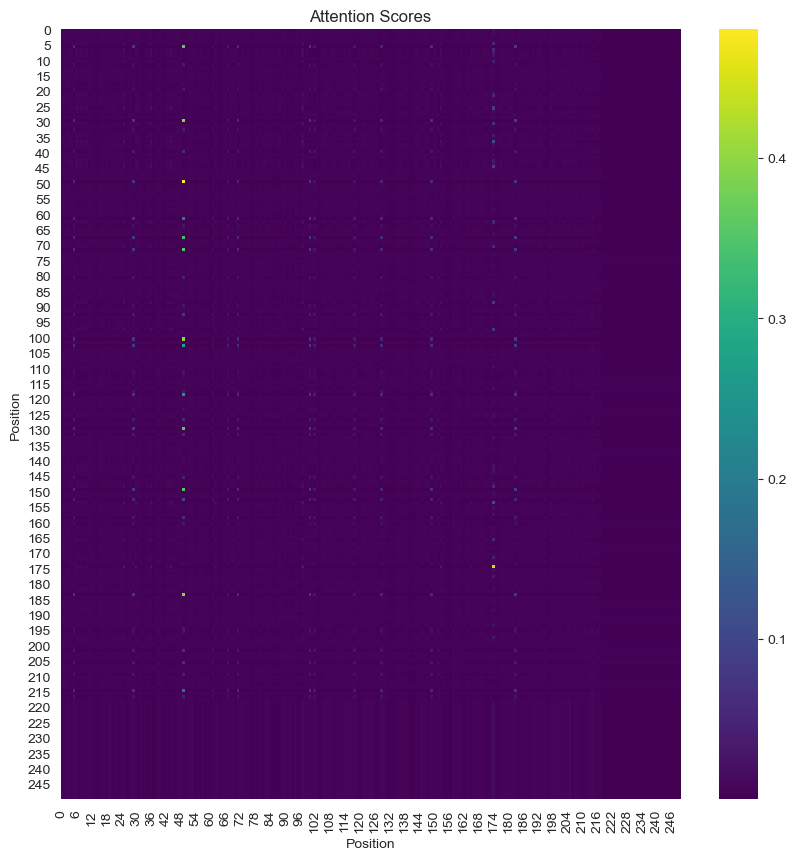

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(attention_scores, cmap='viridis')
plt.title('Attention Scores')
plt.xlabel('Position')
plt.ylabel('Position')
plt.show()

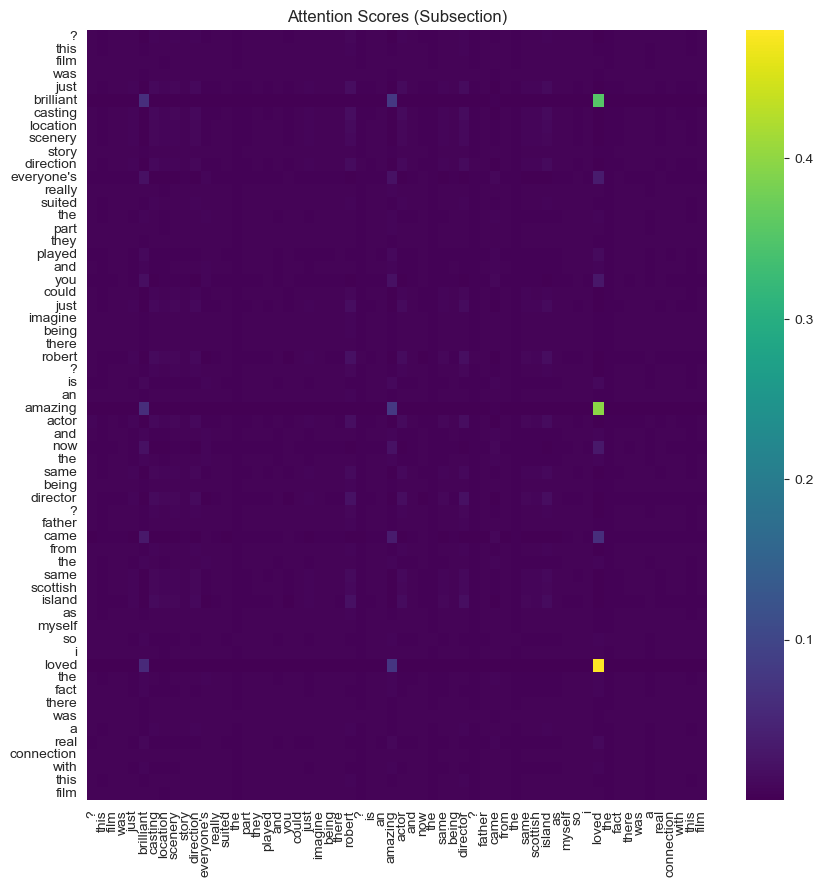

In [47]:
sub_length = 60  # Adjust the length of the subsection as needed
sub_scores = attention_scores[:sub_length, :sub_length]

# Plot the attention scores for the subsection
plt.figure(figsize=(10, 10))
sns.heatmap(sub_scores, cmap='viridis',
            xticklabels=[index_to_word.get(i - 3, '?') for i in sample_input[0][:sub_length]],
            yticklabels=[index_to_word.get(i - 3, '?') for i in sample_input[0][:sub_length]])
plt.title('Attention Scores (Subsection)')
plt.show()
